In [28]:
import pandas as pd
import numpy as np
import xgboost
import time
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import gc
import pickle

In [29]:
start_time = time.time()
data_folder = 'data'
sample_frac = 0.1

In [30]:
correlated_cols = pd.read_pickle('data/high_corr_features.pickle')
print(len(correlated_cols))

dropped_features_refcv1 = pd.read_pickle('data/refcv_custom_dropped_cols.pickle')
print(len(dropped_features_refcv1))

21
62


In [31]:
data_full_features = pd.read_pickle('data/train_full_features.pickle')
data_full_features.drop(correlated_cols, axis=1, inplace=True)
data_full_features.drop(dropped_features_refcv1, axis=1, inplace=True)

# sampling
data_full_features = data_full_features.sample(frac=sample_frac, random_state=1).reset_index(drop=True)

# split to X, y
drop_cols = ['order_id', 'user_id', 'product_id', 'reordered']
X = data_full_features.drop(drop_cols, axis=1)
y = data_full_features['reordered']

m = X.shape[1]
print(X.shape)
# split on user level
cv_split_base = data_full_features['user_id']

# release memory
gc.collect(); del data_full_features

(847466, 130)


In [32]:
# model
xgb_params = {
    'n_estimators': 1000
    , "objective": "binary:logistic"
    , "eval_metric": ['auc', 'logloss']
    , "eta": 0.1
    , "max_depth": 6
    , "min_child_weight": 10
    , "gamma": 0.70
    , "subsample": 0.76
    , "colsample_bytree": 0.8
    , "alpha": 2e-05
    , "lambda": 10
    , "tree_method": 'hist'
    , "early_stopping_rounds": 30
    , "random_state": 19
    , "predictor": 'cpu_predictor'
}
bst = xgboost.XGBClassifier(**xgb_params)

In [33]:
def refcv(X, y, min_features, step, cv_split_base, val_frac=0.2):
    cv_res = {'cv_train_logloss': [], 'cv_train_auc': [], 'cv_val_logloss': [], 'cv_val_auc': []}
    cv_train_logloss, cv_train_auc, cv_val_logloss, cv_val_auc, num_features_changes, cols_dropped = [], [], [], [], [], []
    num_iter = int(np.ceil((X.shape[1] - min_features)/step))
    # for i in tqdm(range(num_iter)):
    for i in trange(num_iter):
        train_logloss, val_logloss, train_auc, val_auc = [], [], [], []
        num_features_changes.append(X.shape[1])
        for train_idx, test_idx in GroupKFold(n_splits=3).split(X, y, groups=cv_split_base):
            # performance in each fold with i features
            X_train, X_val = X.loc[train_idx], X.loc[test_idx]
            y_train, y_val = y.loc[train_idx], y.loc[test_idx]

            bst.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
            res = bst.evals_result()
            train_logloss.append(res["validation_0"]["logloss"][-1])
            val_logloss.append(res["validation_1"]["logloss"][-1])
            train_auc.append(res["validation_0"]["auc"][-1])
            val_auc.append(res["validation_1"]["auc"][-1])
        
        # save mean of cv results
        cv_res['cv_train_logloss'].append(np.mean(train_logloss))
        cv_res['cv_train_auc'].append(np.mean(train_auc))
        cv_res['cv_val_logloss'].append(np.mean(val_logloss))
        cv_res['cv_val_auc'].append(np.mean(val_auc))

        # refit full data to get feature importance
        train_size = int(np.round(X.shape[0] * (1-val_frac)))
        val_size = X.shape[0] - train_size
        bst.fit(X.iloc[:train_size, ], y.iloc[:train_size, ], 
                eval_set=[(X.iloc[:train_size, ], y.iloc[:train_size, ]), 
                          (X.iloc[-val_size:, ], y.iloc[-val_size:, ])], verbose=False)
        if X.shape[1] - step < min_features:
            final_step = X.shape[1] - min_features
            min_idx = np.argsort(bst.feature_importances_)[:final_step]
        else:
            min_idx = np.argsort(bst.feature_importances_)[:step]
        to_drop_cols = list(X.columns[min_idx])
        cols_dropped.append(to_drop_cols)
        print('Drop feature(s)', to_drop_cols)
        X = X.drop(to_drop_cols, axis=1)
        print('{} features left'.format(X.shape[1]))
    return cv_res, num_features_changes, cols_dropped

In [34]:
min_features = 80
step = 1
cv_res, num_features_change, cols_dropped  = refcv(X, y, min_features=min_features, step=step, cv_split_base=cv_split_base)

  0%|          | 0/50 [00:00<?, ?it/s]

Drop feature(s) ['p_max_similarity_score']


  2%|▏         | 1/50 [05:24<4:25:23, 324.97s/it]

129 features left
Drop feature(s) ['p_embedding_15']


  4%|▍         | 2/50 [10:56<4:23:07, 328.91s/it]

128 features left
Drop feature(s) ['p_embedding_1']


  6%|▌         | 3/50 [16:37<4:21:49, 334.25s/it]

127 features left
Drop feature(s) ['p_embedding_29']


  8%|▊         | 4/50 [22:21<4:19:18, 338.24s/it]

126 features left
Drop feature(s) ['user_department_unique']


 10%|█         | 5/50 [28:01<4:14:15, 339.01s/it]

125 features left
Drop feature(s) ['up_norm_purchases_dow_5']


 12%|█▏        | 6/50 [33:18<4:02:54, 331.23s/it]

124 features left
Drop feature(s) ['users_purchases_dow_1']


 14%|█▍        | 7/50 [39:09<4:02:08, 337.88s/it]

123 features left
Drop feature(s) ['p_embedding_4']


 16%|█▌        | 8/50 [44:24<3:51:22, 330.53s/it]

122 features left
Drop feature(s) ['p_embedding_26']


 18%|█▊        | 9/50 [50:00<3:46:56, 332.12s/it]

121 features left
Drop feature(s) ['user_std_order_dow']


 20%|██        | 10/50 [55:05<3:35:52, 323.80s/it]

120 features left
Drop feature(s) ['p_embedding_11']


 22%|██▏       | 11/50 [1:00:33<3:31:22, 325.19s/it]

119 features left
Drop feature(s) ['user_std_order_hour']


 24%|██▍       | 12/50 [1:06:04<3:26:58, 326.80s/it]

118 features left
Drop feature(s) ['users_purchases_pod_noon']


 26%|██▌       | 13/50 [1:11:37<3:22:49, 328.90s/it]

117 features left
Drop feature(s) ['user_mean_order_dow']


 28%|██▊       | 14/50 [1:16:59<3:16:02, 326.74s/it]

116 features left
Drop feature(s) ['users_gluten_free_ratio']


 30%|███       | 15/50 [1:22:31<3:11:25, 328.16s/it]

115 features left
Drop feature(s) ['p_embedding_37']


 32%|███▏      | 16/50 [1:27:41<3:02:56, 322.84s/it]

114 features left
Drop feature(s) ['p_embedding_19']


 34%|███▍      | 17/50 [1:33:24<3:00:57, 329.03s/it]

113 features left
Drop feature(s) ['users_purchases_dow_3']


 36%|███▌      | 18/50 [1:38:21<2:50:18, 319.32s/it]

112 features left
Drop feature(s) ['p_embedding_33']


 38%|███▊      | 19/50 [1:43:30<2:43:25, 316.29s/it]

111 features left
Drop feature(s) ['user_mean_order_hour']


 40%|████      | 20/50 [1:48:35<2:36:21, 312.71s/it]

110 features left
Drop feature(s) ['users_purchases_dow_6']


 42%|████▏     | 21/50 [1:53:46<2:30:55, 312.26s/it]

109 features left
Drop feature(s) ['user_basket_size_skew']


 44%|████▍     | 22/50 [1:59:07<2:26:55, 314.84s/it]

108 features left
Drop feature(s) ['p_embedding_16']


 46%|████▌     | 23/50 [2:04:19<2:21:18, 314.02s/it]

107 features left
Drop feature(s) ['p_embedding_28']


 48%|████▊     | 24/50 [2:09:16<2:13:54, 309.02s/it]

106 features left
Drop feature(s) ['up_cart_order_std']


 50%|█████     | 25/50 [2:14:24<2:08:38, 308.75s/it]

105 features left
Drop feature(s) ['p_embedding_18']


 52%|█████▏    | 26/50 [2:19:20<2:01:57, 304.91s/it]

104 features left
Drop feature(s) ['p_embedding_5']


 54%|█████▍    | 27/50 [2:24:06<1:54:41, 299.20s/it]

103 features left
Drop feature(s) ['p_embedding_35']


 56%|█████▌    | 28/50 [2:28:57<1:48:44, 296.57s/it]

102 features left
Drop feature(s) ['p_embedding_39']


 58%|█████▊    | 29/50 [2:34:16<1:46:09, 303.30s/it]

101 features left
Drop feature(s) ['p_embedding_2']


 60%|██████    | 30/50 [2:39:11<1:40:19, 300.96s/it]

100 features left
Drop feature(s) ['p_embedding_36']


 62%|██████▏   | 31/50 [2:44:20<1:36:06, 303.48s/it]

99 features left
Drop feature(s) ['p_embedding_27']


 64%|██████▍   | 32/50 [2:49:17<1:30:27, 301.53s/it]

98 features left
Drop feature(s) ['uo_unique_aisle_std']


 66%|██████▌   | 33/50 [2:54:02<1:23:58, 296.36s/it]

97 features left
Drop feature(s) ['p_avg_first_order_num']


 68%|██████▊   | 34/50 [2:58:51<1:18:29, 294.35s/it]

96 features left
Drop feature(s) ['p_embedding_31']


 70%|███████   | 35/50 [3:04:07<1:15:09, 300.65s/it]

95 features left
Drop feature(s) ['up_department_purchase_trend_d1']


 72%|███████▏  | 36/50 [3:09:12<1:10:27, 301.94s/it]

94 features left
Drop feature(s) ['p_num_purchases_per_user_max']


 74%|███████▍  | 37/50 [3:14:00<1:04:32, 297.89s/it]

93 features left
Drop feature(s) ['p_embedding_3']


 76%|███████▌  | 38/50 [3:18:51<59:09, 295.78s/it]  

92 features left
Drop feature(s) ['p_embedding_14']


 78%|███████▊  | 39/50 [3:23:46<54:09, 295.41s/it]

91 features left
Drop feature(s) ['p_num_products_sim_score_0.5_0.6']


 80%|████████  | 40/50 [3:28:36<48:58, 293.84s/it]

90 features left
Drop feature(s) ['p_embedding_8']


 82%|████████▏ | 41/50 [3:33:31<44:07, 294.20s/it]

89 features left
Drop feature(s) ['user_basket_size_trend_d1']


 84%|████████▍ | 42/50 [3:38:22<39:05, 293.20s/it]

88 features left
Drop feature(s) ['up_purchases_dow_0']


 86%|████████▌ | 43/50 [3:43:00<33:41, 288.81s/it]

87 features left
Drop feature(s) ['up_aisle_purchase_trend_d1']


 88%|████████▊ | 44/50 [3:48:06<29:23, 293.85s/it]

86 features left
Drop feature(s) ['users_purchases_pod_morning']


 90%|█████████ | 45/50 [3:52:37<23:55, 287.18s/it]

85 features left
Drop feature(s) ['p_embedding_17']


 92%|█████████▏| 46/50 [3:57:11<18:52, 283.23s/it]

84 features left
Drop feature(s) ['up_word2vec_07_substitute_purchases']
83 features left


 94%|█████████▍| 47/50 [4:01:57<14:12, 284.07s/it]

Drop feature(s) ['p_embedding_6']
82 features left


 96%|█████████▌| 48/50 [4:06:49<09:32, 286.32s/it]

Drop feature(s) ['p_embedding_13']


 98%|█████████▊| 49/50 [4:11:27<04:43, 283.90s/it]

81 features left
Drop feature(s) ['p_std_first_reorder_diff']


100%|██████████| 50/50 [4:16:26<00:00, 307.72s/it]

80 features left


In [35]:
cols_dropped

[['p_max_similarity_score'],
 ['p_embedding_15'],
 ['p_embedding_1'],
 ['p_embedding_29'],
 ['user_department_unique'],
 ['up_norm_purchases_dow_5'],
 ['users_purchases_dow_1'],
 ['p_embedding_4'],
 ['p_embedding_26'],
 ['user_std_order_dow'],
 ['p_embedding_11'],
 ['user_std_order_hour'],
 ['users_purchases_pod_noon'],
 ['user_mean_order_dow'],
 ['users_gluten_free_ratio'],
 ['p_embedding_37'],
 ['p_embedding_19'],
 ['users_purchases_dow_3'],
 ['p_embedding_33'],
 ['user_mean_order_hour'],
 ['users_purchases_dow_6'],
 ['user_basket_size_skew'],
 ['p_embedding_16'],
 ['p_embedding_28'],
 ['up_cart_order_std'],
 ['p_embedding_18'],
 ['p_embedding_5'],
 ['p_embedding_35'],
 ['p_embedding_39'],
 ['p_embedding_2'],
 ['p_embedding_36'],
 ['p_embedding_27'],
 ['uo_unique_aisle_std'],
 ['p_avg_first_order_num'],
 ['p_embedding_31'],
 ['up_department_purchase_trend_d1'],
 ['p_num_purchases_per_user_max'],
 ['p_embedding_3'],
 ['p_embedding_14'],
 ['p_num_products_sim_score_0.5_0.6'],
 ['p_embe

In [36]:
cols_dropped_flat = [item for sublist in cols_dropped for item in sublist]
cols_dropped_flat

['p_max_similarity_score',
 'p_embedding_15',
 'p_embedding_1',
 'p_embedding_29',
 'user_department_unique',
 'up_norm_purchases_dow_5',
 'users_purchases_dow_1',
 'p_embedding_4',
 'p_embedding_26',
 'user_std_order_dow',
 'p_embedding_11',
 'user_std_order_hour',
 'users_purchases_pod_noon',
 'user_mean_order_dow',
 'users_gluten_free_ratio',
 'p_embedding_37',
 'p_embedding_19',
 'users_purchases_dow_3',
 'p_embedding_33',
 'user_mean_order_hour',
 'users_purchases_dow_6',
 'user_basket_size_skew',
 'p_embedding_16',
 'p_embedding_28',
 'up_cart_order_std',
 'p_embedding_18',
 'p_embedding_5',
 'p_embedding_35',
 'p_embedding_39',
 'p_embedding_2',
 'p_embedding_36',
 'p_embedding_27',
 'uo_unique_aisle_std',
 'p_avg_first_order_num',
 'p_embedding_31',
 'up_department_purchase_trend_d1',
 'p_num_purchases_per_user_max',
 'p_embedding_3',
 'p_embedding_14',
 'p_num_products_sim_score_0.5_0.6',
 'p_embedding_8',
 'user_basket_size_trend_d1',
 'up_purchases_dow_0',
 'up_aisle_purchas

In [37]:
# fig, axes = plt.subplots(2, 1)
# axes[0].plot(num_features_change, cv_res['cv_train_logloss'], label='train_logloss')
# axes[0].plot(num_features_change, cv_res['cv_val_logloss'], label='val_logloss')
# axes[0].legend()

# axes[1].plot(num_features_change, cv_res['cv_train_auc'], label='train_auc')
# axes[1].plot(num_features_change, cv_res['cv_val_auc'], label='val_auc')
# axes[1].legend()


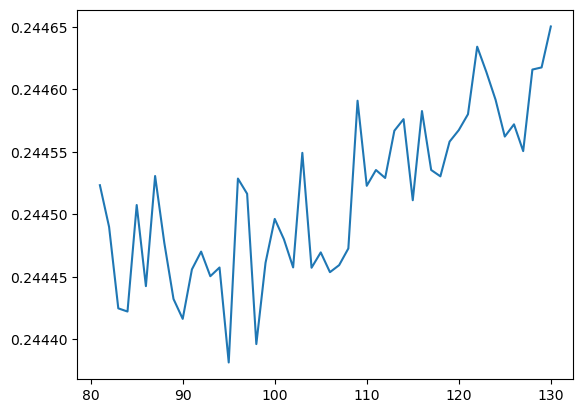

In [38]:
plt.plot(num_features_change, cv_res['cv_val_logloss'], label='val_logloss')

In [63]:
best_n_logloss = num_features_change[np.argmin(cv_res['cv_val_logloss'])]
print('Best Number of Features: ', best_n_logloss)
print('Min Logloss', np.min(cv_res['cv_val_logloss']))

Best Number of Features:  95
Min Logloss 0.2443815493541535


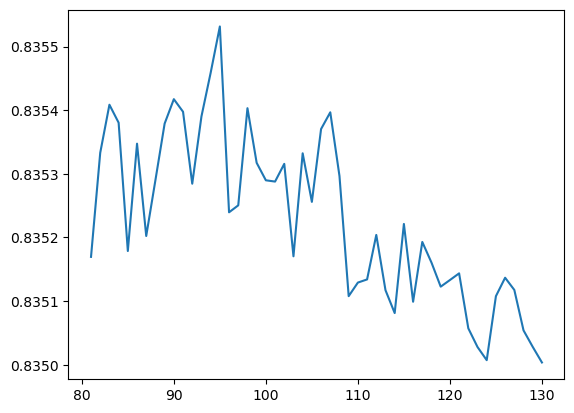

In [40]:
plt.plot(num_features_change, cv_res['cv_val_auc'], label='val_auc')

In [64]:
best_n_auc = num_features_change[np.argmax(cv_res['cv_val_auc'])]
print('Best Number of Features: ', best_n_auc)
print('Max Logloss', np.min(cv_res['cv_val_auc']))

Best Number of Features:  95
Max Logloss 0.8350034762645006


In [70]:
best_cols_to_drop = cols_dropped_flat[:m-best_n_auc]
len(best_cols_to_drop)

35

In [42]:
with open('data/refcv_custom_dropped_cols_r2.pickle', 'wb+') as f:
    pickle.dump(best_cols_to_drop, f)

In [43]:
cv_res_df = pd.DataFrame(cv_res)
cv_res_df['num_features'] = num_features_change
cv_res_df.shape

(50, 5)

In [44]:
cv_res_df.to_pickle('data/cv_res_df_from_130_to_80.pickle')

In [45]:
end_time = time.time()
time_spent = (end_time - start_time) / 60
print('spent {:.2f} mins'.format(time_spent))

spent 257.83 mins


In [52]:
cv_res_df1 = pd.read_pickle('data/cv_res_df_from_192_to_130.pickle')
cv_res_df1.head()

,cv_train_logloss,cv_train_auc,cv_val_logloss,cv_val_auc,num_features
0,0.231773,0.858291,0.244692,0.834897,192
1,0.231171,0.859312,0.244731,0.834974,191
2,0.232139,0.857675,0.244706,0.834899,190
3,0.232172,0.857577,0.244676,0.834939,189
4,0.232402,0.857207,0.244736,0.834852,188


In [53]:
cv_res_df_total = pd.concat([cv_res_df1, cv_res_df], ignore_index=True)
cv_res_df_total.shape

(112, 5)

In [56]:
cv_res_df_total.loc[cv_res_df_total.num_features==130]

,cv_train_logloss,cv_train_auc,cv_val_logloss,cv_val_auc,num_features
62,0.232076,0.857719,0.24465,0.835003,130


Text(0.5, 1.0, 'Logloss')

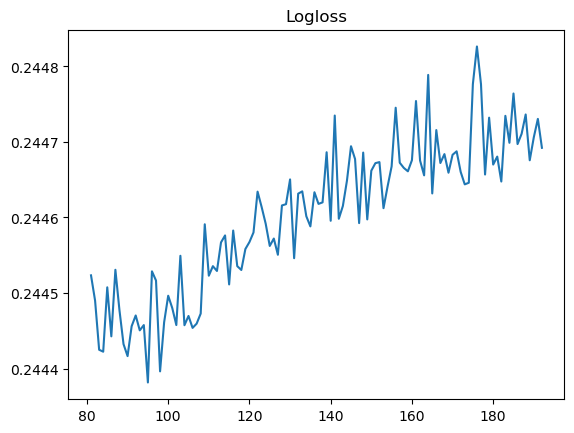

In [60]:
plt.plot(cv_res_df_total['num_features'], cv_res_df_total['cv_val_logloss'])
plt.title('Logloss')